## HW6 by Denis Osipychev
# Proximal Policy Optimization Algorithms

### Hyper parameters and service functions

In [1]:
# import env and modules
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [2]:
# create an instance of env
env = gym.make('Pendulum-v0')
env.reset()

array([-0.85939927,  0.5113051 ,  0.19142354])

In [11]:
class PPOagent():
    def __init__(self, s_size,a_size,h_size):
        
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        
        # Value network
        hidden1 = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.value = slim.fully_connected(hidden1,1,biases_initializer=None,activation_fn=None)
        
        # loss for V network
        self.v_target = tf.placeholder(shape=[None],dtype=tf.float32)
        self.v_loss = tf.reduce_mean(tf.square(self.v_target - self.value))
        self.v_optimizer = tf.train.AdamOptimizer(alpha_v).minimize(self.v_loss)
        
        
        # Policy network
        hidden2 = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.tanh)
        self.p_mean = slim.fully_connected(hidden2,a_size,activation_fn=tf.nn.tanh,biases_initializer=None)
        self.p_var = slim.fully_connected(hidden2,a_size,activation_fn=tf.nn.softplus,biases_initializer=None)
        prob_distr = tf.distributions.Normal(loc=self.p_mean, scale=self.p_var)
        self.action = prob_distr.sample(1)
        self.log_prob = prob_distr.log_prob(self.action)
                        
        # loss for Policy network (A value)
        self.old_log_prob = tf.placeholder(shape=[None],dtype=tf.float32)
        self.a_target = tf.placeholder(shape=[None],dtype=tf.float32)
               
        ratio = tf.exp(self.log_prob - self.old_log_prob) # pnew / pold
        surr_loss = ratio * self.a_target # surrogate from conservative policy iteration
        surr_loss_clip = tf.clip_by_value(ratio, 1.0 - 0.2, 1.0 + 0.2) * self.a_target #
        entropy = tf.reduce_mean(tf.exp(self.log_prob)*self.log_prob)
        self.p_loss = - tf.reduce_mean(tf.minimum(surr_loss, surr_loss_clip)) - 0.01 * entropy
        self.p_optimizer = tf.train.AdamOptimizer(alpha_p).minimize(self.p_loss)

In [12]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)

In [13]:
def compute_v(r_batch, v_new_batch):
    v_next = np.asarray(v_new_batch).squeeze()
    r = np.asarray(r_batch).squeeze()
    return r + v_next*gamma
    
def compute_a(discounted_r, v):
    v_targ = np.asarray(discounted_r).squeeze()
    v = np.asarray(v).squeeze()
    gae = v_targ - v
    return gae

In [14]:
# initialize hyperparams for PG
n_episodes = 10000
episode_length = 200
gamma = 0.9
alpha_v = 1e-3
alpha_p = 1e-3
lambd = lam = 1
epsilon = 0.2
update_freq = 100
buffer_size = 1000
batch_size = 100

In [15]:
# TF variables reset
tf.reset_default_graph()
myAgent = PPOagent(s_size=3,a_size=1,h_size=20)
init = tf.global_variables_initializer()

In [16]:
with tf.Session() as sess:
    
    sess.run(init)
    
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    
    stats = []
    vloss, ploss = 0, 0
    buffer = ReplayMemory(buffer_size)
    i_episode = 0
    
    while i_episode < n_episodes:
        
        s = env.reset()
        s = np.array(s).reshape(1, 3)
        running_reward = 0
        trajectory = []
        i_episode += 1
        var = []
        
        for t in range(episode_length):
            
            action, plog, pvar = sess.run([myAgent.action,myAgent.log_prob,myAgent.p_var],
                                     feed_dict={myAgent.state_in:s})

            s_new,r,d,_ = env.step(action)
            
            var.append(pvar)
            
            #populate the trajectory
            trajectory.append([s,action,r,s_new,plog])
            #buffer.push([s,action,r,s_new,plog])
    
            prev_action = action
            s = np.array(s_new).reshape(1, 3)
            running_reward += r
            
            if d == True:
                break
        
        buffer.push(trajectory)
        
        if i_episode % update_freq == 0:
    
            vloss, ploss = 0, 0
    
            # sample the trajectories
            batch = buffer.sample(batch_size)
        
            #do update for each trajectory in the batch
            for traj in batch:
                s_arr, a_arr, r_arr, s_new_arr, p_arr = zip(*traj)
                
                v_new_arr = sess.run(myAgent.value, feed_dict={myAgent.state_in:np.asarray(s_new_arr).squeeze()})
                v_target_arr = compute_v(r_arr,v_new_arr)
                
                v_arr = sess.run(myAgent.value, feed_dict={myAgent.state_in:np.asarray(s_arr).squeeze()})
                a_target_arr = compute_a(v_target_arr, v_arr)
        
                _, vl = sess.run([myAgent.v_optimizer, myAgent.v_loss],
                                 feed_dict={myAgent.state_in:np.asarray(s_arr).squeeze(),
                                            myAgent.v_target:np.asarray(v_target_arr).squeeze()})
                
                _, pl = sess.run([myAgent.p_optimizer, myAgent.p_loss],
                                 feed_dict={myAgent.state_in:np.asarray(s_arr).reshape(len(s_arr),3),
                                            myAgent.old_log_prob:np.asarray(p_arr).reshape(len(p_arr)),
                                            myAgent.a_target:np.asarray(a_target_arr).reshape(len(a_target_arr))})
                                 
                vloss += vl
                ploss += pl
                
            vloss /= batch_size
            ploss /= batch_size
                    
        # Update statistics
        stats.append([i_episode,running_reward/len(trajectory),vloss,ploss,np.asarray(var).mean()])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,
                  ',Average R:',np.mean(np.asarray(stats)[-100:,1]),
                  'V_loss:', np.mean(np.asarray(stats)[-100:,2]),
                  'P_loss:',np.mean(np.asarray(stats)[-100:,3]),
                    'var:',np.mean(np.asarray(stats)[-100:,4]))
    

 Epoch: 100 ,Average R: -6.237343816757202 V_loss: 0.5972490505218506 P_loss: 0.14811285614967346 var: 0.7130182138085366
 Epoch: 200 ,Average R: -6.404433641433716 V_loss: 59.78313714828491 P_loss: 14.821449342679978 var: 0.7020146489143372
 Epoch: 300 ,Average R: -6.44769766330719 V_loss: 65.62899638366699 P_loss: 15.981919785499574 var: 0.7370478641986847
 Epoch: 400 ,Average R: -6.39533576965332 V_loss: 73.78063110084535 P_loss: 31.217677177000052 var: 0.6916502904891968
 Epoch: 500 ,Average R: -6.44246009349823 V_loss: 88.2288345230102 P_loss: 27.48212566213609 var: 0.6889522922039032
 Epoch: 600 ,Average R: -6.414337811470031 V_loss: 104.03091778182988 P_loss: 11.686228901910784 var: 0.691675273180008
 Epoch: 700 ,Average R: -6.453921346664429 V_loss: 118.90035010910033 P_loss: 11.766027110576633 var: 0.6922203594446182
 Epoch: 800 ,Average R: -6.458444676399231 V_loss: 137.38430702667242 P_loss: 15.262532805156706 var: 0.6933990824222565
 Epoch: 900 ,Average R: -6.40747890472412

 Epoch: 7000 ,Average R: -6.392494640350342 V_loss: 53.52935520706177 P_loss: 7.8159099047303195 var: 0.693734148144722
 Epoch: 7100 ,Average R: -6.376474022865295 V_loss: 49.754222750854495 P_loss: 4.890400366699694 var: 0.7151417773962021
 Epoch: 7200 ,Average R: -6.367020936012268 V_loss: 47.34676093139646 P_loss: 4.878928549563885 var: 0.7183139681816101
 Epoch: 7300 ,Average R: -6.3307356357574465 V_loss: 44.78159059123992 P_loss: 5.429674606502057 var: 0.7446565735340118
 Epoch: 7400 ,Average R: -6.32490695476532 V_loss: 41.620276124954216 P_loss: 8.76278045037985 var: 0.7670629227161407
 Epoch: 7500 ,Average R: -6.387186737060547 V_loss: 38.86498676910401 P_loss: 4.652388293075561 var: 0.7273715019226075
 Epoch: 7600 ,Average R: -6.4286339521408085 V_loss: 38.438407140731805 P_loss: 5.024854436969758 var: 0.7058548206090927
 Epoch: 7700 ,Average R: -6.396252460479737 V_loss: 38.541891048431395 P_loss: 4.164119464296103 var: 0.7013249117136001
 Epoch: 7800 ,Average R: -6.41511006

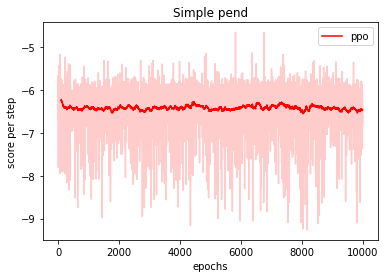

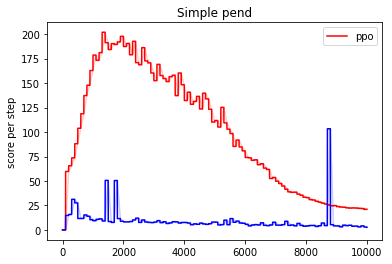

In [17]:
#plot the results (taken from https://gist.github.com/vksah32/8ba7ee7489bd8ec50c995f6216adcb7d)
import pandas as pd
import matplotlib.pyplot as plt 

i,r,vl,pl,var = zip(*stats)
r_np = np.asarray(r).flatten()
i_np = np.asarray(i).flatten()
v_np = np.asarray(vl).flatten()
p_np = np.asarray(pl).flatten()
var_np = np.asarray(var).flatten()

mean_r = pd.Series(r_np).rolling(window=100).mean()
mean_v = pd.Series(v_np).rolling(window=100).mean()
mean_p = pd.Series(p_np).rolling(window=100).mean()
mean_var = pd.Series(var_np).rolling(window=100).mean()

plt.figure(0)
plt.xlabel("epochs")
plt.ylabel("score per step")
plt.plot(i_np, mean_r, 'r-')
plt.plot(i_np, r_np, 'r-', alpha=0.2)
plt.legend(['ppo'])
plt.title('Simple pend')
plt.show()

plt.figure(1)
plt.ylabel("score per step")
plt.plot(i_np, v_np, 'r-')
plt.plot(i_np, p_np, 'b-')
plt.plot(i_np, mean_v, 'r-', alpha=0.2)
plt.plot(i_np, mean_p, 'b-', alpha=0.2)

plt.legend(['ppo'])
plt.title('Simple pend')
plt.show()

## seems to be working now.